In [1]:
import sys

import os
import glob
import json

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

import hyperspy.api as hs

import tensorflow as tf

import pandas as pd

from tqdm import tqdm

from scipy import ndimage
from scipy.optimize import curve_fit

from abtem import CTF
from abtem.transfer import scherzer_defocus
from abtem.noise import poisson_noise
#from abtem.mtf import MTF
from abtem import Waves

In [2]:
def compute_dose_rate(
    intensity,brightness,
    area,exposure):
    '''
    Function to compute dose given intensity integrated over an area
    Brightness calibration and exposure time required
    
    Return dose in units of electrons per angstrom^2 per second
    '''
    dose_rate=(intensity*brightness_cal)/(area*exposure)/100
    
    return dose_rate

def fft(img):
    f = np.fft.fft2(img)
    f = np.fft.fftshift(f)

    # Set zero'th/DC component to 0.0
    c = int(f.shape[0]/2), int(f.shape[1]/2)
    f[c[0], c[1]] = 0.0

    return np.abs(f)

#===================================================================
# Get PSD 1D (total radial power spectrum)
#===================================================================
def GetPSD1D(psd2D):
    
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h,0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))
    psd1D_norm = psd1D#/np.mean(psd1D)
    
    stderr = np.zeros(wc)
    for i in np.arange(wc):
        stderr[i] = ndimage.standard_deviation(psd2D, r, index=i) / np.sqrt(len(r[r==i]))  
    
    #stderr /= np.mean(psd1D)
    
    # Skip zero'th/DC component
    return psd1D_norm, r#, stderr[1:]
#===================================================================

#=============================================================================
# Get PSD 1D (total power spectrum by angular bin)
#=============================================================================
def GetRPSD(psd2D, dTheta, rMin, rMax):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2
    
    # note that displaying PSD as image inverts Y axis
    # create an array of integer angular slices of dTheta
    Y, X  = np.ogrid[0:h, 0:w]
    theta = np.rad2deg(np.arctan2(-(Y-hc), (X-wc)))
    theta = np.mod(theta + dTheta/2 + 360, 360)
    theta = dTheta * (theta//dTheta)
    theta = theta.astype(np.int)
    
    # mask below rMin and above rMax by setting to -100
    R     = np.hypot(-(Y-hc), (X-wc))
    mask  = np.logical_and(R > rMin, R < rMax)
    theta = theta + 100
    theta = np.multiply(mask, theta)
    theta = theta - 100
    
    # SUM all psd2D pixels with label 'theta' between rMin and rMax
    angF  = np.arange(0, 360, int(dTheta))
    #psd1D = ndimage.sum(psd2D, theta, index=angF)
    psd1D = ndimage.mean(psd2D, theta, index=angF)
    
    # normalize each sector to the total sector power
    pwrTotal = np.sum(psd1D)
    psd1D    = psd1D/pwrTotal
    
    return angF, psd1D, theta
#=============================================================================

In [3]:
def mtf(x,c0,c1,C):
    # 1-Dimensional MTF
    return (1-C)*(1/(1 + (x/c0)**c1)) + C

test_mtf1d = mtf

def mtf1d_fit(x, c0, c1, c2, c3):
    # 1-Dimensional MTF for fitting
    return (c1-c2)*(1/(1 + (x/c0)**c3)) + c2

# Exerpimental Data Noise Fit

Now let's do the same thing with some experimental noise, where we don't know the exact MTF.

In [4]:
folder='../experimental_data/Au-CeO2-contdoseseries'
files=glob.glob(f'{folder}/Hour_*/Minute_*/Second_*/*.dm4')
print('No. of frames: ', len(files))

No. of frames:  402


In [5]:
# Load in experimental data

take = files#[::10]#files[:-29]
exps = []
for i,f in enumerate(take):
    exp_hs = hs.load(f)
    
    frame_metadata = exp_hs.original_metadata.as_dictionary()
    
    if i == 0:
        brightness_cal_frame1 = frame_metadata['ImageList']['TagGroup0']['ImageData']['Calibrations']['Brightness']['Scale']
        scale_frame1 = exp_hs.axes_manager.signal_axes[0].scale
    
    brightness_cal = frame_metadata['ImageList']['TagGroup0']['ImageData']['Calibrations']['Brightness']['Scale']
    if brightness_cal == 1.0:
        frame_metadata['ImageList']['TagGroup0']['ImageData']['Calibrations']['Brightness']['Scale'] = brightness_cal_frame1
        brightness_cal = frame_metadata['ImageList']['TagGroup0']['ImageData']['Calibrations']['Brightness']['Scale']
    exposure = frame_metadata['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']

    x_cal,y_cal = exp_hs.axes_manager.signal_axes[0].scale, exp_hs.axes_manager.signal_axes[1].scale
    if x_cal == 1.0:
        exp_hs.axes_manager.signal_axes[0].scale = exp_hs.axes_manager.signal_axes[1].scale = scale_frame1
        x_cal,y_cal = exp_hs.axes_manager.signal_axes[0].scale, exp_hs.axes_manager.signal_axes[1].scale
        
    
    x_size,y_size = exp_hs.axes_manager.signal_axes[0].size, exp_hs.axes_manager.signal_axes[1].size
    x_nm, y_nm = x_cal*x_size, y_cal*y_size

    data_tmp = exp_hs.data
    #data_tmp = ( data_tmp-np.mean(data_tmp) )/ np.std(data_tmp)
    exps.append(exp_hs)

## Select frame

In [6]:
frame = -1
exp_hs = exps[frame]

In [7]:
s_x = exp_hs.axes_manager.signal_axes[0].scale*10 # sampling in Å/px
s_y = exp_hs.axes_manager.signal_axes[1].scale*10 # sampling in Å/px

qN = 1/(2*s_x) # Nyquist Frequency

In [8]:
# Get all 2D Power spectrums
size = 500
exp_psd2ds = []
dose_rate_list = []
for i, exp in enumerate(tqdm(exps)):
    exp = exp.data
    exp_roi = (exp.shape[0]-size, 0)
    roi = exp[ exp_roi[1]:exp_roi[1]+size, exp_roi[0]:exp_roi[0]+size ]
    #roi = ( roi-np.mean(roi) )/ np.std(roi)
    exp_psd2ds.append(fft(roi))
    area = roi.shape[0]*roi.shape[1]*(x_cal*y_cal)
    dose_rate_list.append(compute_dose_rate(roi.sum(),brightness_cal,area,exposure))
dose_rates=np.array(dose_rate_list)

100%|██████████| 402/402 [00:21<00:00, 18.81it/s] 


## Figure SOI7 (SOI6 if frame = 0)

In [9]:
# Define the low frequency cut off
qx = np.fft.fftshift(np.fft.fftfreq(roi.shape[0], d=s_x)) / qN
qy = np.fft.fftshift(np.fft.fftfreq(roi.shape[1], d=s_y)) / qN

exp_psd2d = exp_psd2ds[frame]
exp_psd1d, exp_azmask = GetPSD1D(exp_psd2d)

size_in_ang = exp_psd2d.shape[0]*s_x
q_cut = 1/size_in_ang # low frequency cut off
q_half = qx[int((roi.shape[0]/2)):]
cut_idxs = np.where(q_half >= q_cut)
q_fit = q_half[cut_idxs] # remove low frequencies below cutoff
f_fit = exp_psd1d[cut_idxs]

In [10]:
x = q_fit
f = f_fit

popt, _ = curve_fit(mtf1d_fit,
                    x, f,
                    bounds=((0, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf)),
                    maxfev=10000
                   )

In [11]:
# residual sum of squares
ss_res_fit = np.sum((f - mtf1d_fit(x,*popt)) ** 2)
# total sum of squares
ss_tot_fit = np.sum((f - np.mean(f)) ** 2)
# r-squared
r2_fit = 1 - (ss_res_fit / ss_tot_fit)

In [12]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].scatter(x, f, 
               facecolors='none',
               edgecolors='b',
               alpha=0.5,
               label='Azimuthally Averaged Power Spectral Density')
axs[0].plot(q_half, mtf1d_fit(q_half,*popt), label='Curve fit',color='orange')
axs[0].set_ylabel('Power Spectral Density [A.U.]', fontsize=18)

textstr1 = r'$(c_1 - c_2) \cdot \frac{1}{1+(\tilde{q}/c_0)^{c_3}} + c_2$'
textstr2 = r'$R^2$ = {:.2f}'.format(r2_fit) + '\n' + '\n' + \
           r'$c_0$ = {:.2f};  $c_1$ = {:.2f}'.format(popt[0],popt[1]) + '\n' + '\n' + \
           r'$c_2$ = {:.2f};  $c_3$ = {:.2f}'.format(popt[2],popt[3])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
axs[0].text(0.5, 0.77, textstr1, transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', horizontalalignment='left', bbox=props)
axs[0].text(0.5, 0.6, textstr2, transform=axs[0].transAxes, fontsize=18,
        verticalalignment='top', horizontalalignment='left', bbox=props)

axs[1].plot(q_half, mtf1d_fit(q_half, *popt)/popt[1])
axs[1].set_ylabel('Normalised Power Spectral Density [A.U.]', fontsize=18)

textstr1 = r'$(1 - C) \cdot \frac{1}{1+(\tilde{q}/c_0)^{c_3}} + C$'
textstr2 = r'$c_0$ = {:.2f};  $c_3$ = {:.2f}'.format(popt[0],popt[3]) + '\n' + '\n' + \
           r'$C$ = {:.2f}'.format(popt[2]/popt[1])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
axs[1].text(0.5, 0.77, textstr1, transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', horizontalalignment='left', bbox=props)
axs[1].text(0.5, 0.6, textstr2, transform=axs[1].transAxes, fontsize=18,
        verticalalignment='top', horizontalalignment='left', bbox=props)

axs[0].legend(fontsize=15)
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].yaxis.offsetText.set_fontsize(18)
for ax in axs:
    ax.grid(True, which='major')
    ax.set_xlabel(r'$q/q_N$', fontsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.gcf().set_dpi(300)
#plt.savefig('Noisefit_framelast.png')
plt.show()

In [13]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].scatter(x, f, 
               facecolors='none',
               edgecolors='b',
               alpha=0.5,
               label='Azimuthally Averaged Power Spectral Density')
axs[0].plot(q_half, mtf1d_fit(q_half,*popt), label='Curve fit',color='orange')
axs[0].set_ylabel('Power Spectral Density [A.U.]', fontsize=18)

axs[1].plot(q_half, mtf1d_fit(q_half, *popt)/popt[1])
axs[1].set_ylabel('Normalised Power Spectral Density [A.U.]', fontsize=18)

axs[0].legend(fontsize=15)
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].yaxis.offsetText.set_fontsize(18)
for ax in axs:
    ax.grid(True, which='major')
    ax.set_xlabel(r'$q/q_N$', fontsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.gcf().set_dpi(300)
#plt.savefig('Noisefit_framelast.png')
plt.show()

# Fit all frames

In [14]:
r2 = np.zeros(len(exp_psd2ds))
c0 = np.zeros(len(exp_psd2ds))
c1 = np.zeros(len(exp_psd2ds))
c2 = np.zeros(len(exp_psd2ds))
c3 = np.zeros(len(exp_psd2ds))

for i,exp_psd2d_tmp in enumerate(exp_psd2ds):
    exp_psd1d_tmp,_ = GetPSD1D(exp_psd2d_tmp)
    f_tmp = exp_psd1d_tmp[cut_idxs]

    try:
        popt_tmp, _ = curve_fit(mtf1d_fit,
                                x, f_tmp,
                                bounds=((0, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf))
                                )
    except RuntimeError:
        continue
    
    # residual sum of squares
    ss_res_fit_tmp = np.sum((f_tmp - mtf1d_fit(x,*popt_tmp)) ** 2)
    # total sum of squares
    ss_tot_fit_tmp = np.sum((f_tmp - np.mean(f_tmp)) ** 2)
    # r-squared
    r2_fit_tmp = 1 - (ss_res_fit_tmp / ss_tot_fit_tmp)

    r2[i] = r2_fit_tmp
    c0[i] = popt_tmp[0]
    c1[i] = popt_tmp[1]
    c2[i] = popt_tmp[2]
    c3[i] = popt_tmp[3]
    #print('LM fit: R2 = {:.3f}, c0={:.2f}, c1={:.2f}, c2={:.2f}, c3={:.2f}'.format(r2_fit_tmp, *popt_tmp))
    #print(f'c0={popt_tmp[0]:.3f}, c1={popt_tmp[3]:.3f}, C={popt_tmp[2]/popt_tmp[1]:.3f}')

In [15]:
c0[ c0 == 0] = np.nan
c1[ c1 == 0] = np.nan
c2[ c2 == 0] = np.nan
c3[ c3 == 0] = np.nan

In [16]:
idxs = np.where(r2 >= 0.98)
x = dose_rates

x_good = x[idxs]
r2_good = r2[idxs]
c0_good = c0[idxs]
c1_good = c1[idxs]
c2_good = c2[idxs]
c3_good = c3[idxs]

In [17]:
C = c2/c1
C_good = C[idxs]

In [18]:
dose = dose_rates*exposure
dose_good = dose[idxs]

## Figure 5

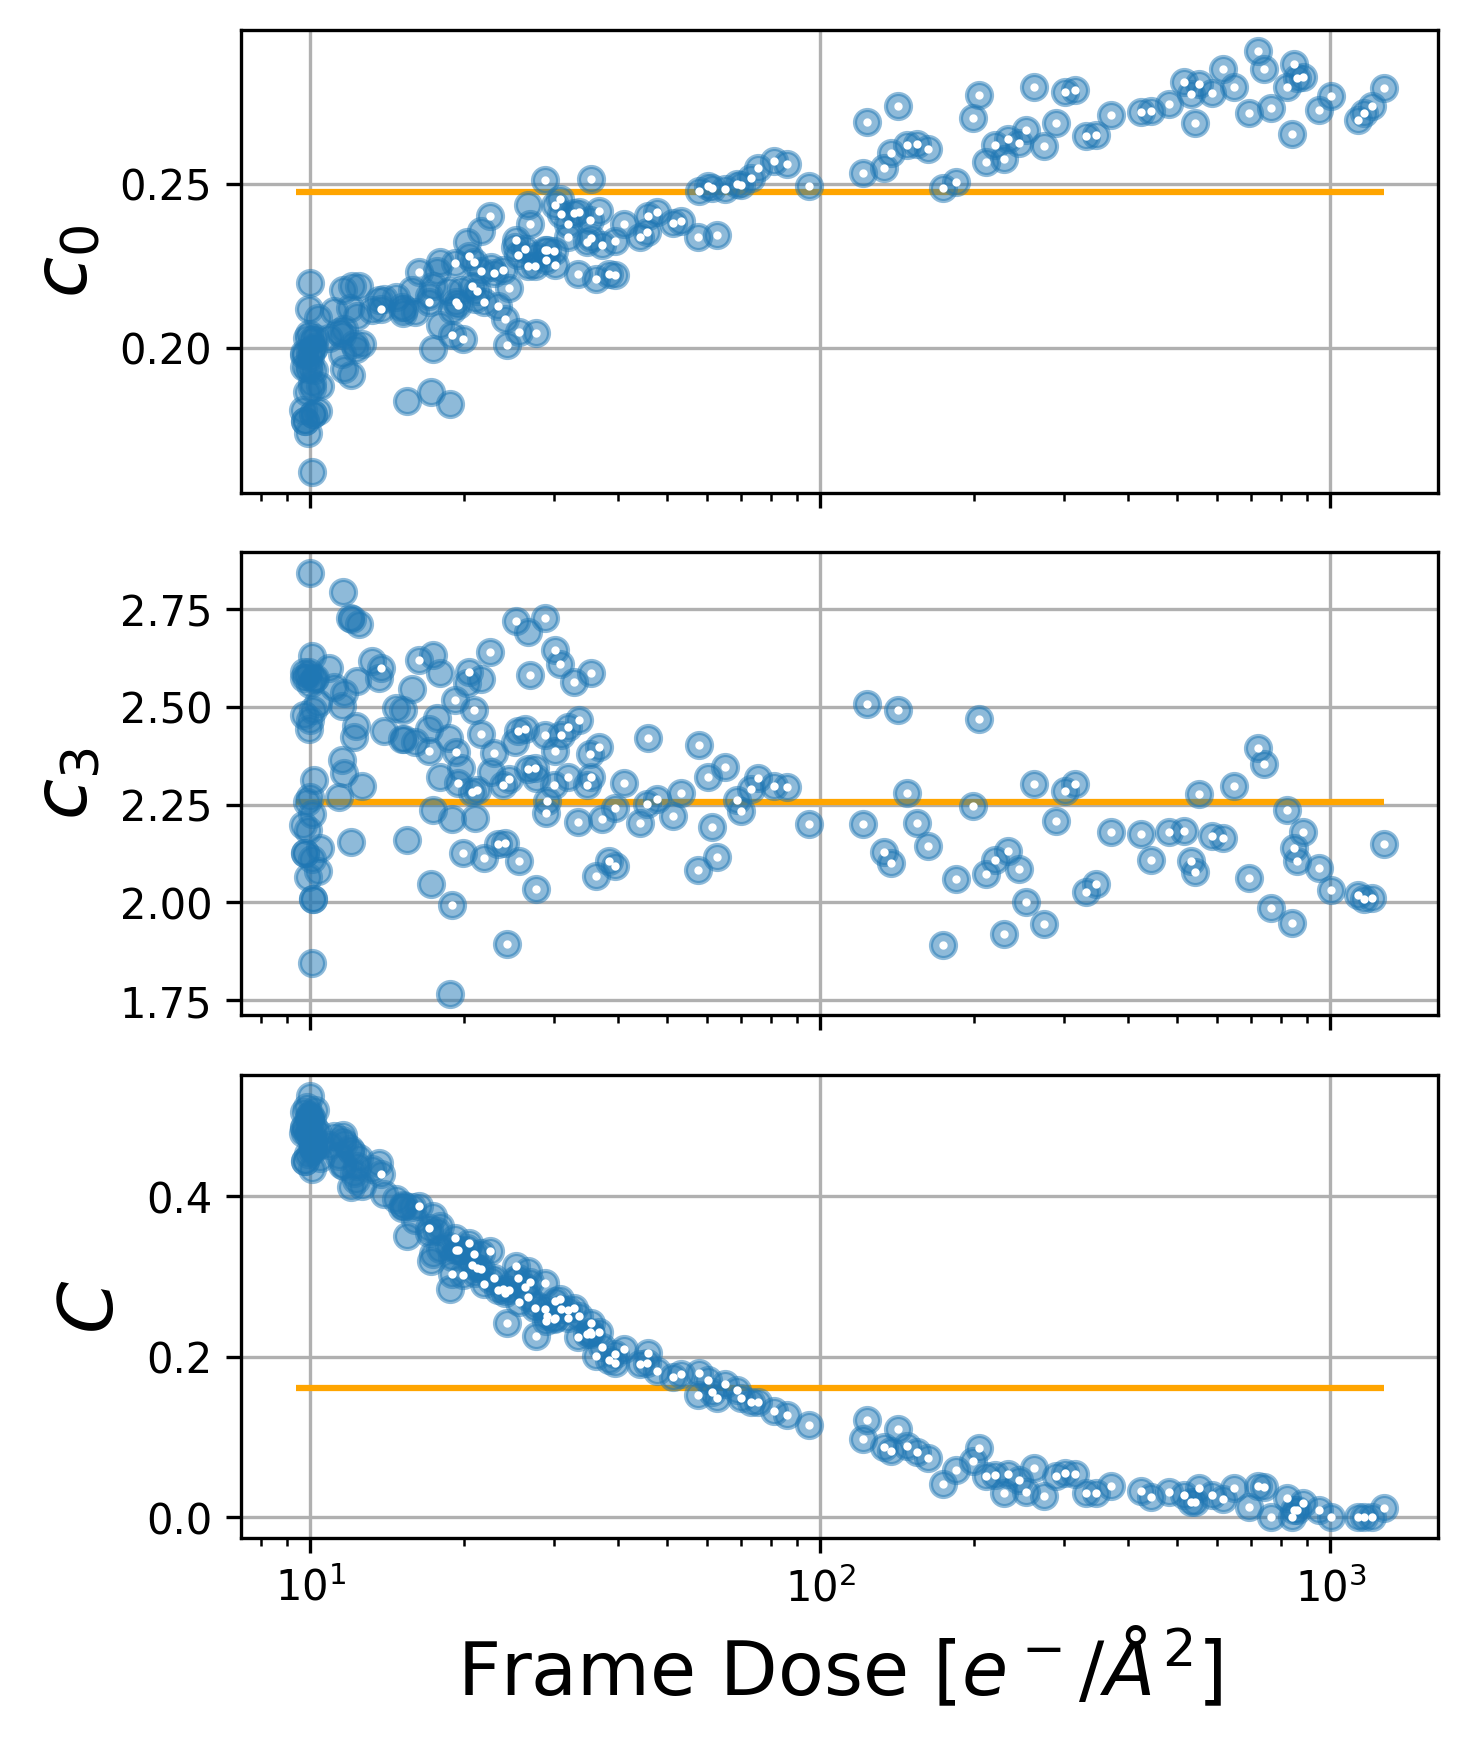

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

fig, axs = plt.subplots(3,1,figsize=(5,6))

axs[0].plot(dose, c0, 'o', alpha=0.5)
axs[0].plot(dose_good, c0_good, 'wo', markersize=1, alpha=1)
axs[0].hlines(xmin=np.min(dose), xmax=np.max(dose), y=np.mean(c0_good), color='orange')

axs[1].plot(dose, c3, 'o', alpha=0.5)
axs[1].plot(dose_good, c3_good, 'wo', markersize=1, alpha=1)
axs[1].hlines(xmin=np.min(dose), xmax=np.max(dose), y=np.mean(c3_good), color='orange')

axs[2].plot(dose, C, 'o', alpha=0.5)
axs[2].plot(dose_good, C_good, 'wo', markersize=1, alpha=1)
axs[2].hlines(xmin=np.min(dose), xmax=np.max(dose), y=np.mean(C_good), color='orange')

axs[0].set_ylabel('$c_0$',fontsize=18)
axs[1].set_ylabel('$c_3$',fontsize=18)
axs[2].set_ylabel('$C$',fontsize=18)

axs[2].set_xlabel('Frame Dose [$e^-$/$Å^2$]',fontsize=18)

axs[0].grid()
axs[1].grid()
axs[2].grid()

for ax in axs:
    ax.set_xscale('log')
axs[0].xaxis.set_major_formatter(NullFormatter())
axs[0].xaxis.set_minor_formatter(NullFormatter())
axs[1].xaxis.set_major_formatter(NullFormatter())
axs[1].xaxis.set_minor_formatter(NullFormatter())

plt.tight_layout()
plt.gcf().set_dpi(300)
# plt.savefig('MTFParameters_DoseDependence.png')
plt.show()

## Figure 6

N0 = 0.011583682020575034, R2 = 0.941980949877268


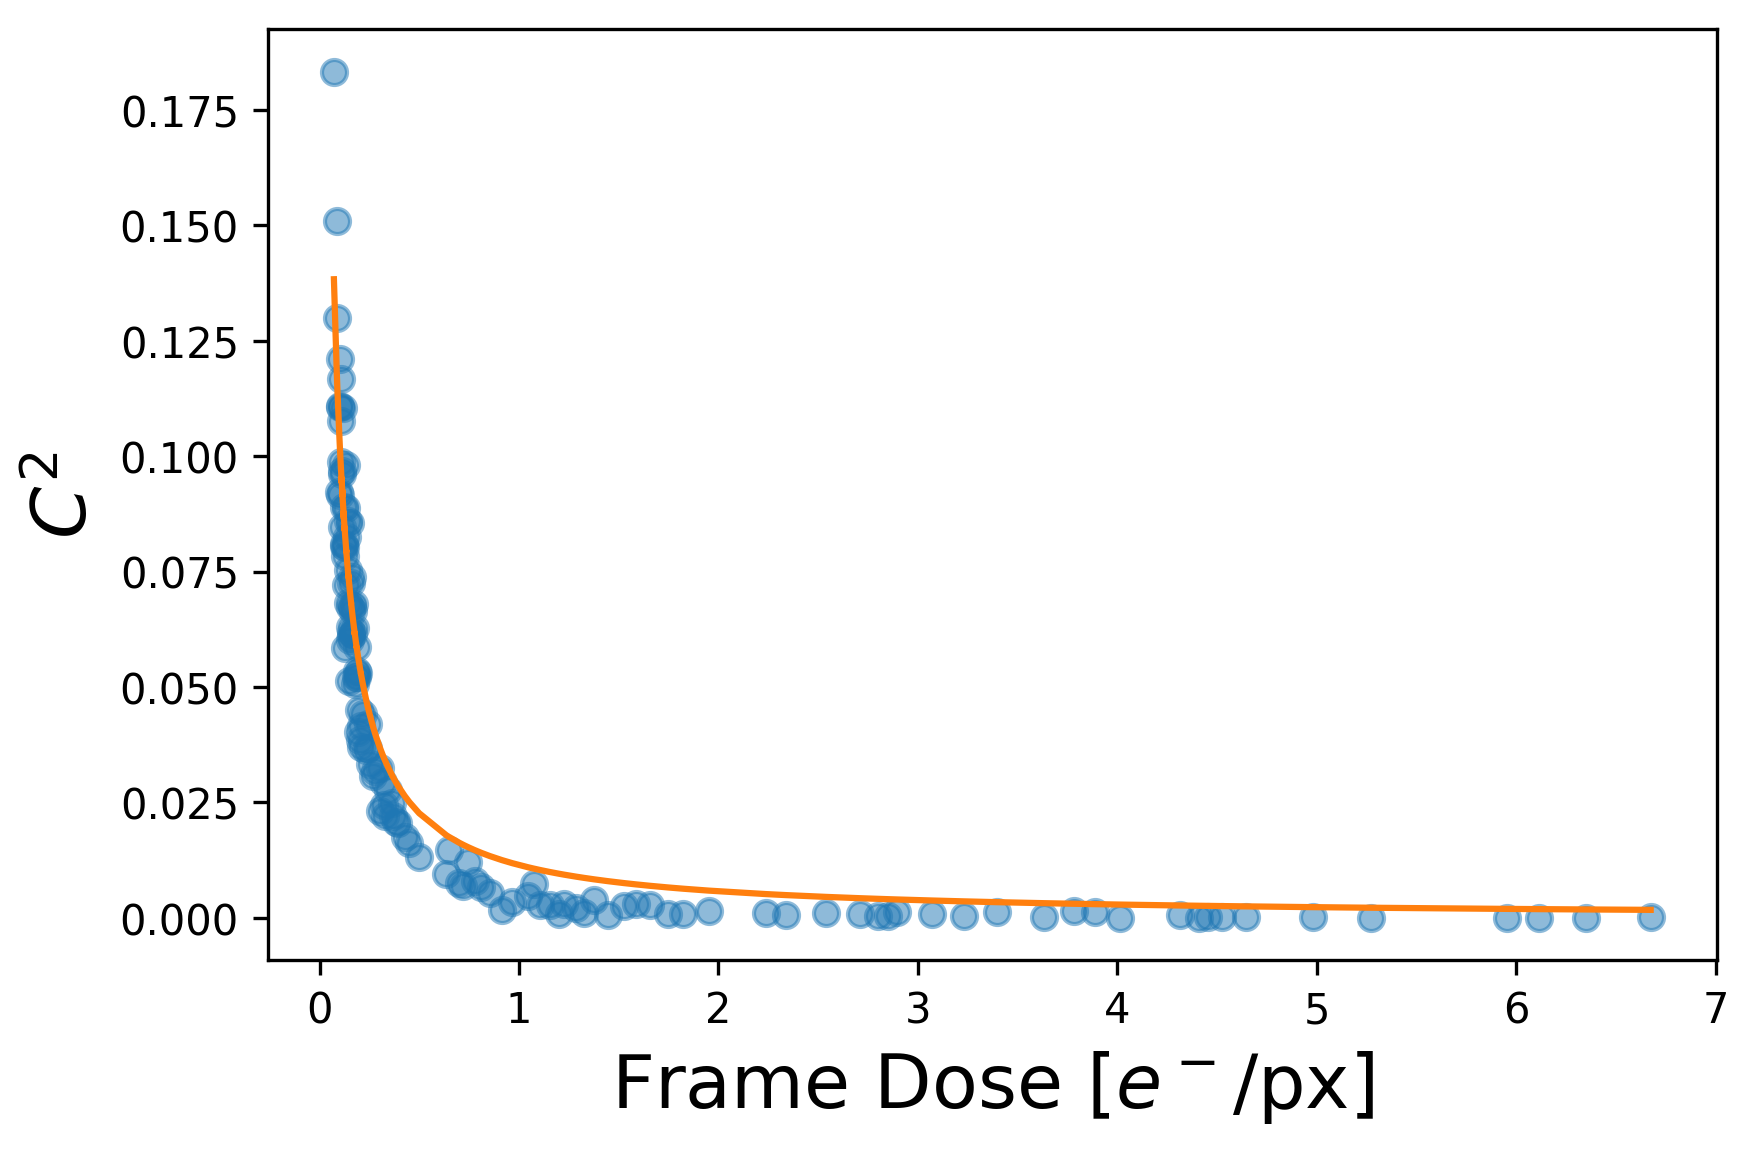

In [20]:
def C_dose(Nd, N0):
    return N0/(Nd+N0)

dose_pixels = dose * ((s_x)**2)
dose_pixels_good = dose_pixels[idxs]

popt_c, _ = curve_fit(C_dose, dose_pixels_good, C_good**2)
line = C_dose(dose_pixels_good, *popt_c)

# residual sum of squares
ss_res_fit = np.sum((C_good**2 - line) ** 2)
# total sum of squares
ss_tot_fit = np.sum((C_good**2 - np.mean(line)) ** 2)
# r-squared
r2_fit = 1 - (ss_res_fit / ss_tot_fit)

plt.plot(dose_pixels_good, C_good**2, 'o', alpha=0.5)
plt.plot(dose_pixels_good, line)

plt.xlabel('Frame Dose [$e^-$/px]',fontsize=18)
plt.ylabel(r'$C^2$',fontsize=18)

plt.tight_layout()
plt.gcf().set_dpi(300)
#plt.savefig('readout_fit.png')
print(f'N0 = {popt_c[0]}, R2 = {r2_fit}')